# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(52, 6)


,title,price,year,link,brand,age
0,"2008 mazda 6, 147k miles, drives great! $3,000...",3000,2008.0,https://charlottesville.craigslist.org/cto/d/c...,mazda,17.0
1,2000 wrangler 4.0 5-spd,10500,2000.0,https://charlottesville.craigslist.org/cto/d/l...,missing,25.0
2,2012 ford mustang premium v6 coupe,13500,2012.0,https://charlottesville.craigslist.org/cto/d/b...,ford,13.0
3,2017 honda accord hybrid,14000,2017.0,https://charlottesville.craigslist.org/cto/d/m...,honda,8.0
4,toyota tacoma 2000,10700,2000.0,https://charlottesville.craigslist.org/cto/d/q...,toyota,25.0


With the data in and wrangled, we can now do some analysis:

count       52.000000
mean     10540.365385
std      11555.710136
min        500.000000
25%       3950.000000
50%       6750.000000
75%      11800.000000
max      62800.000000
Name: price, dtype: float64


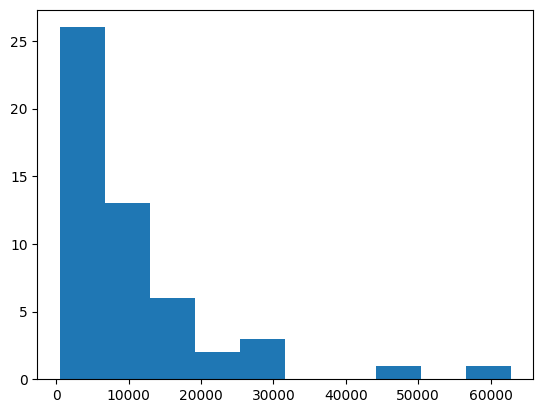

count    48.000000
mean     22.583333
std      15.978487
min       4.000000
25%      11.750000
50%      17.500000
75%      25.750000
max      68.000000
Name: age, dtype: float64


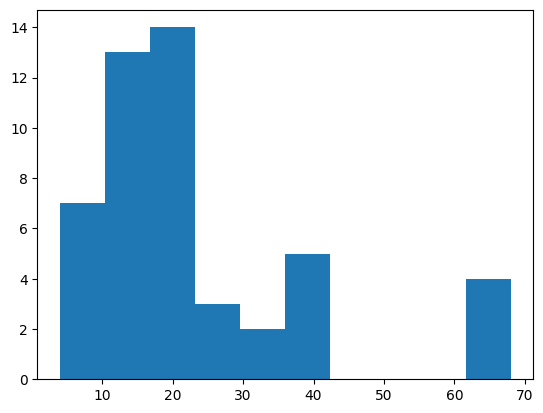

In [5]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [6]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0  12400.000000   6929.646456   7500.0   9950.0  12400.0   
bmw          3.0   8500.000000   1322.875656   7500.0   7750.0   8000.0   
chevrolet    3.0  13333.333333   9802.210635   3000.0   8750.0  14500.0   
chevy        3.0   2600.000000   1931.320792    500.0   1750.0   3000.0   
dodge        1.0   4000.000000           NaN   4000.0   4000.0   4000.0   
ford         6.0  16333.333333  17078.251277   4000.0   6000.0  10500.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda        6.0  12183.333333   9105.474544   4700.0   6050.0   9750.0   
jeep         1.0   9500.000000           NaN   9500.0   9500.0   9500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.5  11175.0   
mazda        1.0   3000.000000           NaN   3000.0   3000.0   3000.0   
missing     16.0   9459.312500  15145.032218   2250.0   3500.0   4500.0   
mitsubishi   1.0   7300.000000           NaN   7300.0   7300.0   7300.0   
subaru       1.0   3600.000000           NaN   3600.0   3600.0   3600.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       2.0   7600.000000   4384.062043   4500.0   6050.0   7600.0   
volkswagen   1.0   2700.000000           NaN   2700.0   2700.0   2700.0   

                              
                75%      max  
brand                         
acura       14850.0  17300.0  
bmw          9000.0  10000.0  
chevrolet   18500.0  22500.0  
chevy        3650.0   4300.0  
dodge        4000.0   4000.0  
ford        16875.0  49500.0  
gmc         21250.0  26000.0  
honda       13750.0  29000.0  
jeep         9500.0   9500.0  
lexus       11287.5  11400.0  
mazda        3000.0   3000.0  
missing      5687.5  62800.0  
mitsubishi   7300.0   7300.0  
subaru       3600.0   3600.0  
tesla       26900.0  26900.0  
toyota       9150.0  10700.0  
volkswagen   2700.0   2700.0

In [7]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0   8.500000   3.535534   6.0   7.25   8.5   9.75  11.0
bmw          3.0  15.666667   1.527525  14.0  15.00  16.0  16.50  17.0
chevrolet    3.0  46.666667  18.475209  36.0  36.00  36.0  52.00  68.0
chevy        3.0  31.333333  10.503968  21.0  26.00  31.0  36.50  42.0
dodge        1.0  22.000000        NaN  22.0  22.00  22.0  22.00  22.0
ford         6.0  16.333333   6.408328   8.0  11.50  17.5  22.00  22.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.00  41.0
honda        6.0  11.666667   5.278889   4.0   8.75  12.0  14.50  19.0
jeep         1.0  12.000000        NaN  12.0  12.00  12.0  12.00  12.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.00  21.0
mazda        1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
missing     13.0  30.230769  21.393745   7.0  13.00  25.0  36.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
subaru       1.0  11.000000        NaN  11.0  11.00  11.0  11.00  11.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       2.0  21.000000   5.656854  17.0  19.00  21.0  23.00  25.0
volkswagen   1.0  22.000000        NaN  22.0  22.00  22.0  22.00  22.0

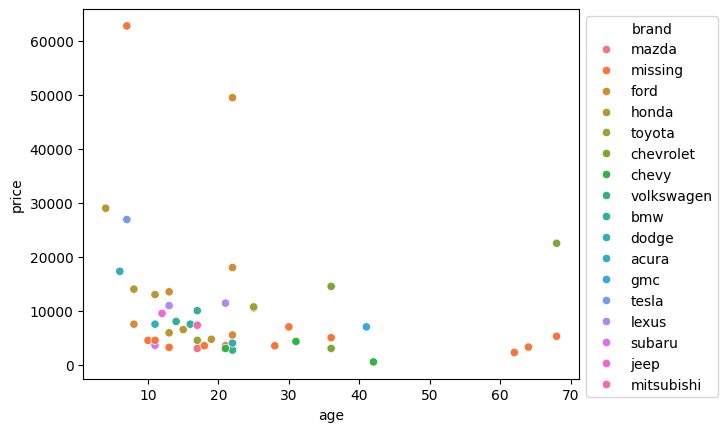

In [8]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.753756 -0.223462
log_age    -0.223462  0.416417
           log_price   log_age
log_price   1.000000 -0.403027
log_age    -0.403027  1.000000


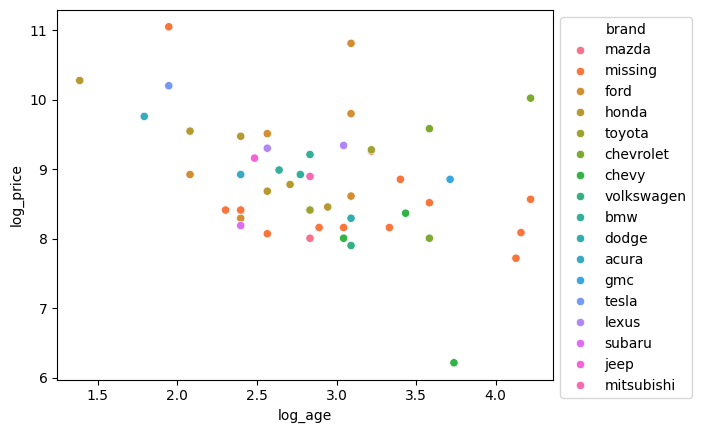

In [9]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

Pulling listings from source code

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup as soup

# Get the page and listing
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/sya#search=1~gallery~0~0'
raw = requests.get(url,headers=header)
bsObj = soup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

Retrieving data and converting to dataframe

In [11]:
import re

brands = ['apple', 'montech', 'alienware', 'purebase', 'thermaltake', 'darkrock', 
          'hp', 'mustex', 'intel', 'amd', 'ryzen', 'acer', 'dell', 'gateway',
          'cougar', 'macbook', 'imac', 'antect', 'jonsbo', 'meshify', 'coolmaster',
          'antect', 'samsung']

processors = ['i9', 'i7', 'i5', 'i3', 'ryzen', 'amd', 'intel', "m4", "m3", "m2", "m1"]

data = []
for k in range(len(listings)):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    words = title.split()
    brand_hits = [word for word in words if word in brands]
    if len(brand_hits) == 0:
        continue # Skip if no brand found
    else:
        brand = brand_hits[0]
        if brand == 'macbook' or brand == 'imac':
            brand = 'apple'
    processor_hits = [word for word in words if word in processors]
    if len(processor_hits) == 0:
        processor = 'intel' # assume intel if no processor found
    else:
        processor = processor_hits[0]
        if processor == 'i9' or processor == 'i7' or processor == 'i5' or processor == 'i3':
            processor = 'intel'
        elif processor == 'ryzen':
            processor = 'amd'
        elif processor == 'm4' or processor == 'm3' or processor == 'm2' or processor == 'm1':
            processor = 'apple silicon'
    data.append({'title':title,'price':price,'link':link,'brand':brand, 'processor':processor})

df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('./src/craigslist_cville_computers.csv')
df.head()

(27, 5)


,title,price,link,brand,processor
0,acer nitro 5 for sale cheap,300,https://charlottesville.craigslist.org/sys/d/r...,acer,intel
1,thermaltake h18 ryzen 7 2700x complete system,750,https://charlottesville.craigslist.org/sys/d/f...,thermaltake,amd
2,antect 902 pc ryzen 7 1700x system,500,https://charlottesville.craigslist.org/sys/d/f...,antect,amd
3,custom darkrock a8-x pc ryzen 7 7700x tower only,1400,https://charlottesville.craigslist.org/sys/d/f...,darkrock,amd
4,custom mustex g07 ryzen 9 7900x tower only,1600,https://charlottesville.craigslist.org/sys/d/f...,mustex,amd


count      27.000000
mean      596.111111
std       405.996716
min        20.000000
25%       325.000000
50%       500.000000
75%       850.000000
max      1600.000000
Name: price, dtype: float64


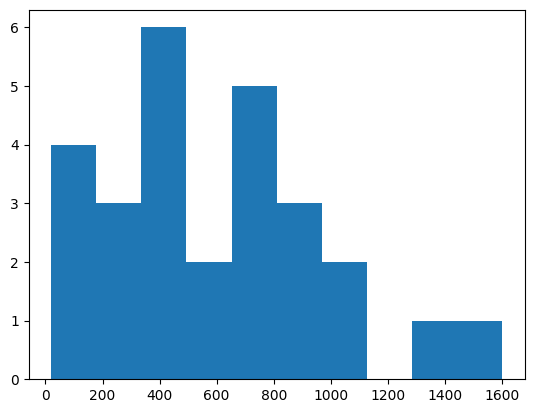

price                                                        \
            count    mean         std     min      25%     50%      75%   
brand                                                                     
acer          2.0   165.0  190.918831    30.0    97.50   165.0   232.50   
alienware     1.0   950.0         NaN   950.0   950.00   950.0   950.00   
antect        1.0   500.0         NaN   500.0   500.00   500.0   500.00   
apple         5.0   324.0  145.361618   120.0   250.00   350.0   400.00   
coolmaster    1.0  1000.0         NaN  1000.0  1000.00  1000.0  1000.00   
cougar        1.0   900.0         NaN   900.0   900.00   900.0   900.00   
darkrock      1.0  1400.0         NaN  1400.0  1400.00  1400.0  1400.00   
dell          2.0   237.5  159.099026   125.0   181.25   237.5   293.75   
gateway       1.0    20.0         NaN    20.0    20.00    20.0    20.00   
hp            2.0   337.5  194.454365   200.0   268.75   337.5   406.25   
intel         1.0   400.0         NaN   400.0   400.00   400.0   400.00   
jonsbo        1.0   700.0         NaN   700.0   700.00   700.0   700.00   
montech       1.0   800.0         NaN   800.0   800.00   800.0   800.00   
mustex        1.0  1600.0         NaN  1600.0  1600.00  1600.0  1600.00   
purebase      2.0   800.0    0.000000   800.0   800.00   800.0   800.00   
ryzen         2.0  1000.0  141.421356   900.0   950.00  1000.0  1050.00   
samsung       1.0   375.0         NaN   375.0   375.00   375.0   375.00   
thermaltake   1.0   750.0         NaN   750.0   750.00   750.0   750.00   

                     
                max  
brand                
acer          300.0  
alienware     950.0  
antect        500.0  
apple         500.0  
coolmaster   1000.0  
cougar        900.0  
darkrock     1400.0  
dell          350.0  
gateway        20.0  
hp            475.0  
intel         400.0  
jonsbo        700.0  
montech       800.0  
mustex       1600.0  
purebase      800.0  
ryzen        1100.0  
samsung       375.0  
thermaltake   750.0

In [12]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
df.loc[:,['price','brand']].groupby('brand').describe()

In [13]:
df.loc[:,['price','processor']].groupby('processor').describe()

price                                                       \
              count        mean         std    min    25%    50%     75%   
processor                                                                  
amd             9.0  994.444444  335.824028  500.0  800.0  900.0  1100.0   
apple silicon   1.0  500.000000         NaN  500.0  500.0  500.0   500.0   
intel          17.0  390.882353  277.281644   20.0  200.0  350.0   475.0   

                       
                  max  
processor              
amd            1600.0  
apple silicon   500.0  
intel           950.0

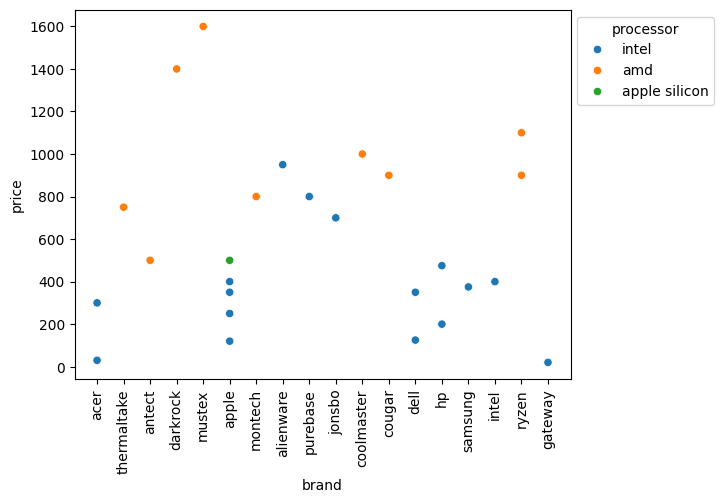

In [14]:
ax = sns.scatterplot(data=df, x='brand', y='price',hue='processor')
plt.xticks(rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))